In [1]:
from twitterscraper import query_tweets
import twitterscraper
import tweepy
from tweepy import OAuthHandler

import re
import string
import sys
import argparse
import json
import pandas as pd
import glob
import numpy as np

import emoji
import datetime
import regex
from collections import Counter
from contractions import CONTRACTION_MAP 
import unicodedata

In [2]:
df_tweets = pd.read_csv('WorkFile.csv')
df_tweets['text'][0]

'Taiwan Can Help #TaiwanCanHelp #COVIDー19 #ChinaLiedPeopleDied  #ChinaVirus  #ChineseVirus  #BlameChina #Washyourhands #WearMask  #StayHome'

In [3]:
# df_tweets = df_tweets[df_tweets['truncated'] == False]
df_tweets.drop(['hashtags', 'urls', 'mentions', 'truncated'], axis=1, inplace=True)
df_tweets.shape

(59046, 3)

In [4]:
def extract_emo_from_text(text):
    emoji_list = []
    tokens = regex.findall(r'\X', text)
    # print(tokens)
    for word in tokens:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    return emoji_list

In [5]:
def extract_emojis(tweets):
    emo = list()
    for tweet in tweets:
        tweet_emos = extract_emo_from_text(tweet)
        emo += tweet_emos
    emo = Counter(emo)
    return emo

In [6]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [7]:
def find_retweeted_clean(tweet):
    re_t, find_m, find_h = None, None, None
    tweet_clean = re.sub('(\\\\[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet.text)
    emos = extract_emojis(tweet_clean)
    for emo in emos:
        tweet_clean = re.sub(emo, ' ', tweet_clean)
    
    '''This function will extract the twitter handles of retweed people'''
    re_t = re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)',tweet_clean)
    tweet_clean = re.sub(':', '', tweet_clean)
    
    if re_t:
        tweet_clean = re.sub('RT', '', tweet_clean)
        tweet_clean = re.sub(re_t[0], '', tweet_clean)
        pass
    else:
        re_t = None
        tweet_clean = tweet.text
    
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    find_m = re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet_clean)
    
    if find_m:
        for find in find_m:
            tweet_clean = re.sub(find, ' ', tweet_clean)
    else:
        find_m = None
        tweet_clean = tweet_clean
    
    '''This function will extract hashtags'''
    find_h = re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet_clean)
    if find_h:
        for find in find_h:
            tweet_clean = re.sub(find, ' ', tweet_clean)
    else:
        find_h = None
        tweet_clean = tweet_clean
    
    '''Takes a string and removes web links from it'''
    tweet_clean = re.sub(r'http\S+', '', tweet_clean) # remove http links
    tweet_clean = re.sub(r'bit.ly/\S+', '', tweet_clean) # rempve bitly links
    tweet_clean = tweet_clean.strip('[link]') # remove [links]
    
    '''Remove accented chars'''
    tweet_clean = unicodedata.normalize('NFKD', tweet_clean).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    
    '''Expanded text'''
    tweet_clean = expand_contractions(tweet_clean)
    
    return tweet_clean, re_t, find_m, find_h, emos

In [8]:
df_tweets['textClean'], df_tweets['retweet'], df_tweets['mentions'], df_tweets['hashtags'], df_tweets['pos_emos'] = zip(*df_tweets.apply(find_retweeted_clean, axis=1))

In [9]:
df_tweets.head()

,author,date,text,textClean,retweet,mentions,hashtags,pos_emos
0,chanwa10,2020-04-02 15:02:20,Taiwan Can Help #TaiwanCanHelp #COVIDー19 #Chin...,Taiwan Can Help 19,None,None,"[#TaiwanCanHelp, #COVID, #ChinaLiedPeopleDied,...",{}
1,SignalBoostShow,2020-04-02 15:02:20,Guest @Indranis_Light spoke w/ @ZerlinaMaxwell...,Guest spoke w/ &amp; about ways in which...,None,"[@Indranis_Light, @ZerlinaMaxwell, @jess_mc]",[#coronavirus],{'📻': 1}
2,TgramSam,2020-04-02 15:02:20,"ESSENTIAL workers; Emergency services, health ...","ESSENTIAL workers; Emergency services, health ...",None,None,"[#Coronavirus, #CoronavirusUK, #CoronavirusCri...",{}
3,Sandeep_jha07,2020-04-02 15:02:20,SCTIMST ties up with Wipro 3D to manufacture a...,SCTIMST ties up with Wipro 3D to manufacture a...,None,None,"[#SCTIMST, #Wipro3D, #AutomatedVentilators, #C...",{}
4,covid_19bot,2020-04-02 15:02:20,Coronavirus Update Country_Region: United Kin...,Coronavirus Update Country_Region: United Kin...,None,None,"[#Coronavirus, #COVID19, #bot]",{}


In [10]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

my_stopwords = nltk.corpus.stopwords.words('english')
my_stopwords.extend(['amp', 'u', 'pleasse','one'])
word_rooter = nltk.stem.WordNetLemmatizer().lemmatize
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@ー'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    if len(tweet_token_list) <2:
        tweet =None
    else:
        tweet = ' '.join(tweet_token_list)
    return tweet


In [11]:
df_tweets['clean_tweet'] = df_tweets.textClean.apply(clean_tweet)
df_tweets.shape

(59046, 9)

In [12]:
df_tweets = df_tweets[df_tweets['clean_tweet'].notna()]
df_tweets.shape

(58626, 9)

In [13]:
from collections import Counter

def splitter_text(text):
    return re.split(' ', text)

word_list = []
for word in df_tweets['clean_tweet'].apply(splitter_text):
    for w in word:
        word_list.append(w)

word_list = list(filter(lambda x: x != "", word_list))
word_list_counter = Counter(word_list).most_common()
len(word_list_counter)

34233

In [14]:
add_stop_words = [word for word, count in word_list_counter if count > 300]
len(add_stop_words)

387

In [15]:
from sklearn.feature_extraction import text 

# Add new stop words
def stopwords_round2(text):
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

    tweet_token_list = [word for word in text.split(' ')
                                if word not in stop_words] # remove stopwords
    tweet = ' '.join(tweet_token_list)
    return tweet

df_tweets['clean_tweetR2'] = df_tweets.clean_tweet.apply(clean_tweet)
df_tweets.head()

,author,date,text,textClean,retweet,mentions,hashtags,pos_emos,clean_tweet,clean_tweetR2
0,chanwa10,2020-04-02 15:02:20,Taiwan Can Help #TaiwanCanHelp #COVIDー19 #Chin...,Taiwan Can Help 19,None,None,"[#TaiwanCanHelp, #COVID, #ChinaLiedPeopleDied,...",{},taiwan help,taiwan help
1,SignalBoostShow,2020-04-02 15:02:20,Guest @Indranis_Light spoke w/ @ZerlinaMaxwell...,Guest spoke w/ &amp; about ways in which...,None,"[@Indranis_Light, @ZerlinaMaxwell, @jess_mc]",[#coronavirus],{'📻': 1},guest spoke w way family member friend bystand...,guest spoke w way family member friend bystand...
2,TgramSam,2020-04-02 15:02:20,"ESSENTIAL workers; Emergency services, health ...","ESSENTIAL workers; Emergency services, health ...",None,None,"[#Coronavirus, #CoronavirusUK, #CoronavirusCri...",{},essential worker emergency service health care...,essential worker emergency service health care...
3,Sandeep_jha07,2020-04-02 15:02:20,SCTIMST ties up with Wipro 3D to manufacture a...,SCTIMST ties up with Wipro 3D to manufacture a...,None,None,"[#SCTIMST, #Wipro3D, #AutomatedVentilators, #C...",{},sctimst tie wipro manufacture automated ventil...,sctimst tie wipro manufacture automated ventil...
4,covid_19bot,2020-04-02 15:02:20,Coronavirus Update Country_Region: United Kin...,Coronavirus Update Country_Region: United Kin...,None,None,"[#Coronavirus, #COVID19, #bot]",{},coronavirus update country region united kingd...,coronavirus update country region united kingd...


In [16]:
df_tweets.to_csv('tweets-after-cleaned.csv')
type(df_tweets['clean_tweetR2'][0])

str

In [17]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
df_tweets_s = pd.DataFrame()
df_tweets_s['text'] = df_tweets['textClean']
df_tweets_s['polarity'] = df_tweets['textClean'].apply(pol)
df_tweets_s['subjectivity'] = df_tweets['textClean'].apply(sub)
df_tweets_s

,text,polarity,subjectivity
0,Taiwan Can Help 19,0.000000,0.000000
1,Guest spoke w/ &amp; about ways in which...,0.175000,0.325000
2,"ESSENTIAL workers; Emergency services, health ...",0.000000,0.300000
3,SCTIMST ties up with Wipro 3D to manufacture a...,0.000000,0.400000
4,Coronavirus Update Country_Region: United Kin...,0.400000,1.000000
...,...,...,...
59041,Bro how?,0.000000,0.000000
59042,bc you will be one of those blasted for your s...,-0.233333,0.929630
59043,#5G is STILL untested for health concerns Man...,0.133333,0.433333
59044,"is watching and laughing, wondering about th...",-0.400000,0.700000


In [18]:
df_tweets_s.replace(0.0, np.nan, inplace=True)
df_tweets_s.dropna(subset=['polarity', 'subjectivity'], how='any', inplace=True)
df_tweets_s.replace(np.nan, 0, inplace=True)
df_tweets_s.to_csv('sentiment-analysis-data.csv')
df_tweets_s_p = df_tweets_s.sample(5000)

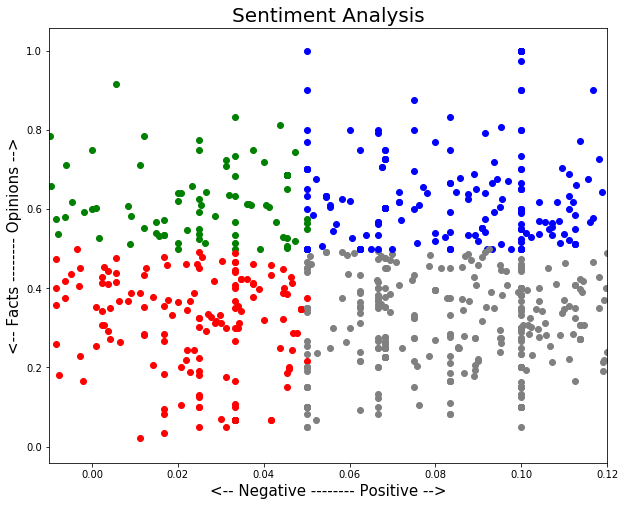

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, ind in enumerate(df_tweets_s_p.index):
    x = df_tweets_s_p.polarity.loc[ind]
    y = df_tweets_s_p.subjectivity.loc[ind]
    if x>= 0.05:
        if y>=0.5:
            plt.scatter(x, y, color='blue')
        else:
            plt.scatter(x, y, color='gray')
    else:
        if y>=0.5:
            plt.scatter(x, y, color='green')
        else:
            plt.scatter(x, y, color='red')
#     plt.text(x+.001, y+.001, data['full_name'][index], fontsize=10)
    plt.xlim(-.01, .12) 

plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

In [20]:
df_tweets.head()

,author,date,text,textClean,retweet,mentions,hashtags,pos_emos,clean_tweet,clean_tweetR2
0,chanwa10,2020-04-02 15:02:20,Taiwan Can Help #TaiwanCanHelp #COVIDー19 #Chin...,Taiwan Can Help 19,None,None,"[#TaiwanCanHelp, #COVID, #ChinaLiedPeopleDied,...",{},taiwan help,taiwan help
1,SignalBoostShow,2020-04-02 15:02:20,Guest @Indranis_Light spoke w/ @ZerlinaMaxwell...,Guest spoke w/ &amp; about ways in which...,None,"[@Indranis_Light, @ZerlinaMaxwell, @jess_mc]",[#coronavirus],{'📻': 1},guest spoke w way family member friend bystand...,guest spoke w way family member friend bystand...
2,TgramSam,2020-04-02 15:02:20,"ESSENTIAL workers; Emergency services, health ...","ESSENTIAL workers; Emergency services, health ...",None,None,"[#Coronavirus, #CoronavirusUK, #CoronavirusCri...",{},essential worker emergency service health care...,essential worker emergency service health care...
3,Sandeep_jha07,2020-04-02 15:02:20,SCTIMST ties up with Wipro 3D to manufacture a...,SCTIMST ties up with Wipro 3D to manufacture a...,None,None,"[#SCTIMST, #Wipro3D, #AutomatedVentilators, #C...",{},sctimst tie wipro manufacture automated ventil...,sctimst tie wipro manufacture automated ventil...
4,covid_19bot,2020-04-02 15:02:20,Coronavirus Update Country_Region: United Kin...,Coronavirus Update Country_Region: United Kin...,None,None,"[#Coronavirus, #COVID19, #bot]",{},coronavirus update country region united kingd...,coronavirus update country region united kingd...


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_tweets['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
tf_feature_names

['#',
 '#billioninterventionfunds',
 '#daylockdown',
 '#daylockdownsa',
 '#dayschallenge',
 '#g',
 '#gdeadlyweapon',
 '#ncov',
 '#s',
 '#theamendmentnow',
 '#u',
 'ab',
 'ability',
 'able',
 'abortion',
 'abroad',
 'absolute',
 'absolutely',
 'abt',
 'abuse',
 'accept',
 'access',
 'according',
 'account',
 'accountable',
 'accurate',
 'across',
 'act',
 'acted',
 'acting',
 'action',
 'activated',
 'active',
 'activity',
 'actor',
 'actual',
 'actually',
 'ad',
 'adam',
 'adapt',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'address',
 'addressing',
 'adjust',
 'admin',
 'administration',
 'admit',
 'admitted',
 'adult',
 'advance',
 'advantage',
 'advice',
 'advise',
 'advised',
 'advocate',
 'affair',
 'affect',
 'affected',
 'affecting',
 'afford',
 'afloat',
 'afraid',
 'africa',
 'african',
 'afternoon',
 'age',
 'aged',
 'agency',
 'agenda',
 'agent',
 'ago',
 'agree',
 'agreed',
 'ahead',
 'ai',
 'aid',
 'aim',
 'aint',
 'air',
 'airborne',
 'aircraft',
 'airline',

In [22]:
tf.shape
data_saver = pd.DataFrame(tf)
data_saver.to_csv('topic-modeling-data.csv')

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 4

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)


In [24]:
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [25]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


In [26]:
no_top_words = 4
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,people,3357.6,help,2589.3,home,1998.7,case,4478.2
1,like,2323.2,pandemic,1382.3,stay,1762.1,new,3799.9
2,get,1987.9,need,1323.5,safe,1099.2,death,3593.0
3,day,1804.7,please,1192.5,coronavirus,1048.7,coronavirus,1648.7
